In [1]:
import pandas as pd #for data wrangling
import geopandas #for visualization
from shapely.geometry import Point  
import matplotlib.pyplot as plt #for visualization
import statsmodels.formula.api as smf #for statistical analysis
import numpy as np #for data wrangling
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
#read in two raw datafiles
nmc_5_0 = pd.read_csv('NMC_5_0.csv')
war_resources = nmc_5_0.drop('version', 1)
inter_state_war_data_4_0 = pd.read_csv('Inter-StateWarData_v4.0.csv')
#drop useless variables
inter_war = inter_state_war_data_4_0.drop(['WarType','StartMonth1', 'StartDay1', 'StartDay2', 'EndDay1', 'EndMonth1', 'EndDay2', 'TransFrom', 'TransTo', 'Version'],1)
#create new varible to merge on
inter_war['EndYear'] = [max(i) for i in zip(inter_war['EndYear1'],inter_war['EndYear2'])]
#merge the data files
war_master = pd.merge(left = war_resources, right = inter_war, left_on = ['ccode', 'year'], right_on = ['ccode', 'StartYear1'], how = 'right')
#remove inconclusive wars
war_master = war_master[(war_master['Outcome'] == 1) | (war_master['Outcome'] == 2)]


In [3]:
#keep variables that are useful and group by side
war_sides = war_master[['WarNum','ccode', 'stateabb', 'milex', 'milper', 'irst', 'pec', 'tpop', 'upop', 'cinc', 'Side']]
war_sides = war_sides.groupby(['WarNum', 'Side']).sum()
war_outcome = war_master[['WarNum', 'Side', 'Outcome']].groupby(['WarNum', 'Side']).agg(pd.Series.mode)
#get dataframe that is indexed by war number and side 
war = pd.merge(left = war_sides, right = war_outcome, left_on = ['WarNum', 'Side'], right_on = ['WarNum','Side'], how = 'left')

In [4]:
war_reg = war.reset_index()
war_reg = war_reg.set_index('WarNum')

#scale the covariates in order to make outcome readable
war_reg['Outcome'] = war_reg['Outcome'].replace({1:1,2:0})
war_reg['milex'] = war_reg['milex']/1000000
war_reg['milper'] = war_reg['milper']/1000
war_reg['irst'] = war_reg['irst']/1000
war_reg['pec'] = war_reg['pec']/1000000
war_reg['tpop'] = war_reg['tpop']/100000
war_reg['upop'] = war_reg['upop']/1000
war_reg['cinc'] = war_reg['cinc']*10

#run probit regression and calculate marginal effect
res_prob = smf.probit('Outcome ~ milex + milper + irst + pec + tpop + upop', data=war_reg).fit()
probit_marg = res_prob.get_margeff(at='overall')
print(probit_marg.summary())
res_prob2 = smf.probit('Outcome ~ cinc', data = war_reg).fit()
probit_marg2 = res_prob2.get_margeff(at='overall')
print(probit_marg2.summary())

Optimization terminated successfully.
         Current function value: 0.653012
         Iterations 6
       Probit Marginal Effects       
Dep. Variable:                Outcome
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
milex         -0.0033      0.005     -0.706      0.480      -0.012       0.006
milper        -0.0315      0.041     -0.763      0.445      -0.112       0.049
irst          -0.0065      0.012     -0.564      0.573      -0.029       0.016
pec            0.2344      0.829      0.283      0.777      -1.390       1.858
tpop          -0.0899      0.047     -1.922      0.055      -0.182       0.002
upop           0.0150      0.005      2.782      0.005       0.004       0.026
Optimization terminated successfully.
         Current function value: 0.667967
         Iterations 5
       Probi

C:\Users\thyang\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


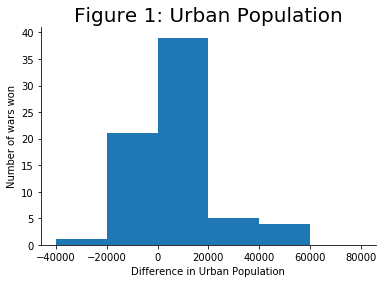

In [5]:
war_upop = war[['upop', 'Outcome']]
war_upop = war_upop.unstack('Side')
#find the difference in urban population between the two sides at war
war_difupop = war_upop[('upop', 1)] - war_upop[('upop', 2)]
#upop histogram construction
fig,ax = plt.subplots()
ax.hist(war_difupop, bins = [-40000,-20000,0,20000,40000,60000,80000])
plt.xlabel('Difference in Urban Population')
plt.ylabel('Number of wars won')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Figure 1: Urban Population', fontsize = 20)
plt.savefig('upop.png')

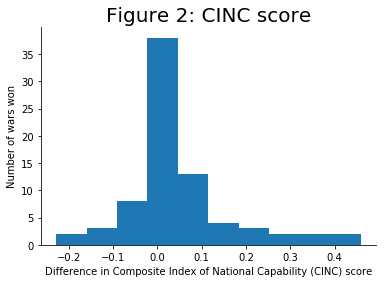

In [6]:
war_cinc = war[['cinc', 'Outcome']]
war_cinc = war_cinc.unstack('Side')
#find the difference in cinc score between the two sides at war
war_dif = war_cinc[('cinc', 1)] - war_cinc[('cinc', 2)]
#cinc histogram construction
fig,ax = plt.subplots(1)
ax.hist(war_dif)
plt.xlabel('Difference in Composite Index of National Capability (CINC) score')
plt.ylabel('Number of wars won')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Figure 2: CINC score', fontsize = 20)
plt.savefig('cinc.png')

In [7]:
#group original data set by country
war_countries = war_master
war_countries['Outcome'] = war_countries['Outcome'].replace({1:1,2:-1})
war_country = war_countries[['cinc', 'stateabb', 'Outcome', 'upop']].groupby(['stateabb']).agg({'upop': 'mean','cinc': 'mean', 'Outcome':'sum'})
#merge data set with geopandas data set that contains 
world = geopandas.read_file('ne_50m_admin_0_countries.shp')
world = world[['ISO_A3', 'geometry']]
war_country = pd.merge(left = world, right = war_country, left_on = 'ISO_A3', right_on = 'stateabb', how = 'left')
war_country = war_country.fillna(0)

          featurecla  scalerank  LABELRANK   SOVEREIGNT SOV_A3  ADM0_DIF  \
0    Admin-0 country          1          3     Zimbabwe    ZWE         0   
1    Admin-0 country          1          3       Zambia    ZMB         0   
2    Admin-0 country          1          3        Yemen    YEM         0   
3    Admin-0 country          3          2      Vietnam    VNM         0   
4    Admin-0 country          5          3    Venezuela    VEN         0   
..               ...        ...        ...          ...    ...       ...   
236  Admin-0 country          1          6      Albania    ALB         0   
237  Admin-0 country          1          3  Afghanistan    AFG         0   
238  Admin-0 country          1          5      Kashmir    KAS         0   
239  Admin-0 country          3          4   Antarctica    ATA         0   
240  Admin-0 country          3          6  Netherlands    NL1         1   

     LEVEL               TYPE            ADMIN ADM0_A3  ...  \
0        2  Sovereign co

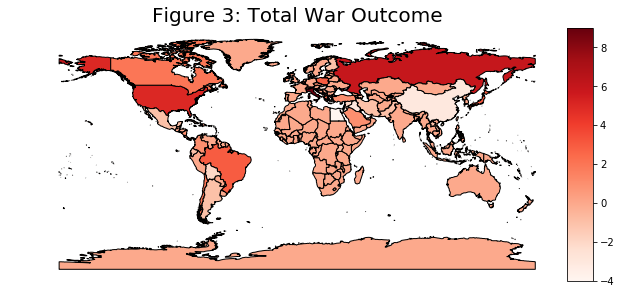

In [16]:
#Draw world map and show net outcome for wars fought by country
fig, gax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(gax)
legend_ax = divider.append_axes('right', size='5%', pad=0.1)
war_country.plot(ax = gax, column='Outcome', edgecolor='black', cmap = 'Reds', legend=True, cax=legend_ax)
gax.axis('off')
gax.set_title('Figure 3: Total War Outcome', fontsize=20)
plt.savefig('country_Outcome.png', bbox_inches='tight')

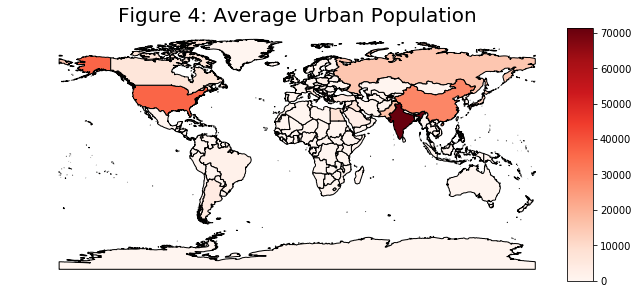

In [17]:
#Draw world map and show average urban population for each country
fig, gax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(gax)
legend_ax = divider.append_axes('right', size='5%', pad=0.1)
war_country.plot(ax = gax, column='upop', edgecolor='black', cmap = 'Reds', legend=True, cax=legend_ax)
gax.axis('off')
gax.set_title('Figure 4: Average Urban Population', fontsize=20)
plt.savefig('country_upop.png', bbox_inches='tight')

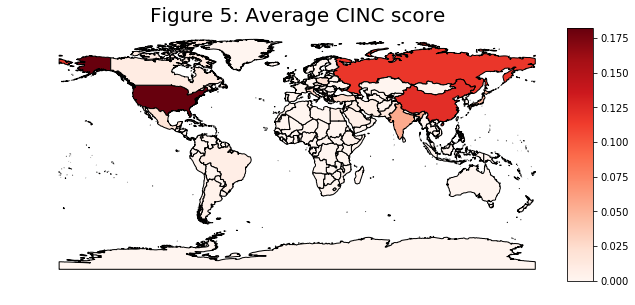

In [18]:
#Draw world map and show average cinc score for each country
fig, gax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(gax)
legend_ax = divider.append_axes('right', size='5%', pad=0.1)
war_country.plot(ax = gax, column='cinc', edgecolor='black', cmap = 'Reds', legend=True, cax=legend_ax)
gax.axis('off')
gax.set_title('Figure 5: Average CINC score', fontsize=20)
plt.savefig('country_cinc.png', bbox_inches='tight')